# Capstone Project - The battle of neighborhoods

## Intro

In this project we will try to find a good location to open a new restaurant in Porto and its adjacent counties. We will make our recommendation based on an expected profit function with some adjustable parameters so we can iterate between optimistic and pessimistic predictions.

Initially, we will not recommend any specific type of restaurant. If enough time is available, we will later recommend a type and price range as well.


## Data

[1]: http://www.ine.pt

The following datasets will be used to perform this analysis:
*	Foursquare API to retrieve venues in the area;
*	Population density per County table; 
*	Price per m2 of new lease agreements by Parish table;
*	Purchase power index by County table;    

All of these tables are public and available at [INE - National Institute of Statistics of Portugal][1]; a webpage which aggregates all kinds of official data for the country, so it should be the most reliable source for our analysis.


In [1]:
#importing all necessary libraries and functions here

import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

## Counties and Boroughs

Officially, the geographic locations in Portugal are divided by Counties which are then divided in Boroughs.
We will attempt to determine the best borough in which to open a restaurant, based on a few different scenarios.

We will start by importing and cleaning the list of counties and boroughs we will be working on and retrieving geographic coordinates for their centroids.

In [2]:
#importing the file
price_df = pd.read_excel('precos_m2.xls', header=None, skiprows=range(9), skipfooter=7 )

price_df.head(5)

,0,1,2,3,4
0,Baguim do Monte (Rio Tinto),11A130412,5.66,NaN,gondomar
1,Lomba,11A130405,NaN,-,NaN
2,Rio Tinto,11A130408,5.68,NaN,NaN
3,União das freguesias de Fânzeres e São Pedro d...,11A130413,4.58,NaN,NaN
4,União das freguesias de Foz do Sousa e Covelo,11A130414,NaN,-,NaN


In [3]:
#properly naming the columns and dropping useless column
columns = ['Borough', 'Code', '€ m2', 'to_drop', 'county']

price_df.columns = columns
price_df.drop('to_drop', axis=1, inplace=True)
price_df.head(5)

,Borough,Code,€ m2,county
0,Baguim do Monte (Rio Tinto),11A130412,5.66,gondomar
1,Lomba,11A130405,NaN,NaN
2,Rio Tinto,11A130408,5.68,NaN
3,União das freguesias de Fânzeres e São Pedro d...,11A130413,4.58,NaN
4,União das freguesias de Foz do Sousa e Covelo,11A130414,NaN,NaN


In [4]:
#Each borough has a unique Code. the 6th and 7th character of the Code are related to the County, let's use it to create a new column with the county and drop the original one

borough_df = price_df.drop('county', axis=1)

Cty_code= borough_df['Code'].str[5:7]

borough_df['County Code'] = Cty_code

#The translation Code - County is as follows

county_dict = {'04' : 'Gondomar', '06' : 'Maia', '08' : 'Matosinhos', '12' : 'Porto', '15' : 'Valongo', '17' : 'Vila Nova de Gaia'}

borough_df['County Name'] = borough_df['County Code'].map(county_dict)

borough_df

,Borough,Code,€ m2,County Code,County Name
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar
1,Lomba,11A130405,NaN,04,Gondomar
2,Rio Tinto,11A130408,5.68,04,Gondomar
3,União das freguesias de Fânzeres e São Pedro d...,11A130413,4.58,04,Gondomar
4,União das freguesias de Foz do Sousa e Covelo,11A130414,NaN,04,Gondomar
5,"União das freguesias de Gondomar (São Cosme), ...",11A130415,4.93,04,Gondomar
6,União das freguesias de Melres e Medas,11A130416,NaN,04,Gondomar
7,Águas Santas,11A130601,5.14,06,Maia
8,Castêlo da Maia,11A130618,5.37,06,Maia
9,Cidade da Maia,11A130619,6.24,06,Maia


Now that we cleaned the list a little, we are ready to add the geographic coordinates of the centroids.

In [5]:
#testing for County

address='Vila Nova de Gaia, PT'

geolocator = Nominatim(user_agent="pt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of VNG are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of VNG are 41.1300103, -8.6058415.


In [6]:
address='Canidelo, Vila Nova de Gaia, PT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Canidelo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Canidelo are 41.1241881, -8.6485236.


In [7]:
address='União de Freguesias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, Porto, PT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of blabla are {}, {}.'.format(latitude, longitude))


AttributeError: 'NoneType' object has no attribute 'latitude'

In [7]:
address='Cedofeita, Porto, PT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cedofeita are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Cedofeita are 41.156076, -8.6227144.


Unfortunately, the Borough division in Portugal underwent a change in 2013 and some of the new Boroughs are now a group of former Boroughs, which doesn't work with the NominateIM. However, it works with each individual former Borough so we will now create a new dataframe with each former Borough

In [8]:
#all of the boroughs we want to split start with 'União de Freguesias de...'

#1st create a mask
is_uniao = borough_df['Borough'].str[0:4] =='Uniã'
#select only lines that need 'treatment'
uni_df=borough_df[is_uniao]
uni_df.head(5)

,Borough,Code,€ m2,County Code,County Name
3,União das freguesias de Fânzeres e São Pedro d...,11A130413,4.58,04,Gondomar
4,União das freguesias de Foz do Sousa e Covelo,11A130414,NaN,04,Gondomar
5,"União das freguesias de Gondomar (São Cosme), ...",11A130415,4.93,04,Gondomar
6,União das freguesias de Melres e Medas,11A130416,NaN,04,Gondomar
17,"União das freguesias de Custóias, Leça do Bali...",11A130811,5.73,08,Matosinhos


All of these Boroughs start with 'União das freguesias de '. Borough names are then divided by ',' and ' e ' if they are the 2 final former Boroughs in the string. We can use this to create a new df keeping the original data of all the other columns.

In [9]:
#let's remove the 1st part of the string
n_chars=len('União das freguesias de ')

uni_df['Borough']=uni_df['Borough'].str[n_chars:]
uni_df.head(5)

<ipython-input-9-ec05eb6785e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_df['Borough']=uni_df['Borough'].str[n_chars:]


,Borough,Code,€ m2,County Code,County Name
3,Fânzeres e São Pedro da Cova,11A130413,4.58,04,Gondomar
4,Foz do Sousa e Covelo,11A130414,NaN,04,Gondomar
5,"Gondomar (São Cosme), Valbom e Jovim",11A130415,4.93,04,Gondomar
6,Melres e Medas,11A130416,NaN,04,Gondomar
17,"Custóias, Leça do Balio e Guifões",11A130811,5.73,08,Matosinhos


In [10]:
#testing split functions
import re

test_1=uni_df['Borough'].loc[5]

rest_1_result=re.split(', | e ',test_1)
print(rest_1_result, len(rest_1_result))

['Gondomar (São Cosme)', 'Valbom', 'Jovim'] 3


In [11]:
# testing the result with parenthesis in the name

address='Gondomar (São Cosme), Gondomar, PT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Canidelo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Canidelo are 41.135273049999995, -8.534103623752394.


In [12]:
address='São Cosme, Gondomar, PT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))

The geograpical coordinate are 41.1398199, -8.5326269.


The results are accurate enough to proceed without requiring extra cleaning. As we don't have more granularity for the € m2 data, we will use the original value from the grouped Borough

In [13]:
#let's create the new split dataframe
split_df = pd.DataFrame(columns = list(uni_df))


for b, c, price, cc, cn in zip(uni_df['Borough'], uni_df['Code'], uni_df['€ m2'], uni_df['County Code'], uni_df['County Name']):
    res=re.split(', | e ',b) #tested and ok
    temp_df=pd.DataFrame(columns = list(uni_df)) #ok
    for a in res:
        temp_df=temp_df.append(
            {'Borough' : a,
            'Code': c,
            '€ m2': price,
            'County Code': cc,
            'County Name': cn},
            ignore_index=True)
    split_df = split_df.append(temp_df)
    
split_df=split_df.reset_index()
split_df

,index,Borough,Code,€ m2,County Code,County Name
0,0,Fânzeres,11A130413,4.58,04,Gondomar
1,1,São Pedro da Cova,11A130413,4.58,04,Gondomar
2,0,Foz do Sousa,11A130414,NaN,04,Gondomar
3,1,Covelo,11A130414,NaN,04,Gondomar
4,0,Gondomar (São Cosme),11A130415,4.93,04,Gondomar
5,1,Valbom,11A130415,4.93,04,Gondomar
6,2,Jovim,11A130415,4.93,04,Gondomar
7,0,Melres,11A130416,NaN,04,Gondomar
8,1,Medas,11A130416,NaN,04,Gondomar
9,0,Custóias,11A130811,5.73,08,Matosinhos


Let's remove the "União" rows from the original dataframe, and merge it with the split df

In [14]:
merged_df=borough_df[~is_uniao].append(split_df)
merged_df.reset_index(inplace=True, drop=True)
merged_df.tail(5)

,Borough,Code,€ m2,County Code,County Name,index
71,Crestuma,11A131729,4.01,17,Vila Nova de Gaia,3.0
72,Santa Marinha,11A131730,7.07,17,Vila Nova de Gaia,0.0
73,São Pedro da Afurada,11A131730,7.07,17,Vila Nova de Gaia,1.0
74,Serzedo,11A131731,5.00,17,Vila Nova de Gaia,0.0
75,Perosinho,11A131731,5.00,17,Vila Nova de Gaia,1.0


Now that the full list of boroughs is done, we can get the geographic coordinates

In [15]:
lats=[]
longs=[]

for bor, cty in zip(merged_df['Borough'],merged_df['County Name']):
    address='{}, {}, PT'.format(bor,cty)
    location = geolocator.geocode(address)
    lats.append(location.latitude)
    longs.append(location.longitude)

merged_df['Latitude']=lats
merged_df['Longitude']=longs

merged_df.head(5)

,Borough,Code,€ m2,County Code,County Name,index,Latitude,Longitude
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar,NaN,41.187473,-8.537759
1,Lomba,11A130405,NaN,04,Gondomar,NaN,41.061741,-8.410817
2,Rio Tinto,11A130408,5.68,04,Gondomar,NaN,41.180717,-8.557569
3,Águas Santas,11A130601,5.14,06,Maia,NaN,41.207759,-8.572750
4,Castêlo da Maia,11A130618,5.37,06,Maia,NaN,41.262712,-8.617064


In [16]:
#a useless column was created, let's remove it.
merged_df.drop('index', axis=1, inplace=True)



In [17]:
#let's reorder by county and reset the index
merged_df = merged_df.sort_values('County Code').reset_index(drop=True)
merged_df.head(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar,41.187473,-8.537759
1,Fânzeres,11A130413,4.58,04,Gondomar,41.171271,-8.542779
2,Covelo,11A130414,NaN,04,Gondomar,41.102164,-8.465754
3,Gondomar (São Cosme),11A130415,4.93,04,Gondomar,41.135273,-8.534104
4,Valbom,11A130415,4.93,04,Gondomar,41.137576,-8.562042


Let's now deal with missing values in the '€ m2' column. 


In [18]:
merged_df[merged_df['€ m2'].isna()]

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude
2,Covelo,11A130414,NaN,04,Gondomar,41.102164,-8.465754
6,Melres,11A130416,NaN,04,Gondomar,41.067700,-8.401182
7,Medas,11A130416,NaN,04,Gondomar,41.057899,-8.438244
9,Foz do Sousa,11A130414,NaN,04,Gondomar,41.099862,-8.495747
10,Lomba,11A130405,NaN,04,Gondomar,41.061741,-8.410817
13,São Pedro Fins,11A130613,NaN,06,Maia,41.245313,-8.553059
14,Vila Nova da Telha,11A130616,NaN,06,Maia,41.247250,-8.673150
19,Folgosa,11A130603,NaN,06,Maia,41.266578,-8.540036
21,Milheirós,11A130608,NaN,06,Maia,41.218151,-8.585451


By personal experience, the boroughs with missing data are not as desirable to live as some of the others. so we will be replacing them with the minimum value of the price per m2 of the County

In [19]:
abc = merged_df.groupby("County Code")['€ m2'].transform(lambda x: x.fillna(x.min()))
merged_df['€ m2']=abc
merged_df = merged_df.sort_values('County Code').reset_index(drop=True)
merged_df.head(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar,41.187473,-8.537759
1,Fânzeres,11A130413,4.58,04,Gondomar,41.171271,-8.542779
2,Covelo,11A130414,4.58,04,Gondomar,41.102164,-8.465754
3,Gondomar (São Cosme),11A130415,4.93,04,Gondomar,41.135273,-8.534104
4,Valbom,11A130415,4.93,04,Gondomar,41.137576,-8.562042


Next we will be adding the rest of the relevant information to the dataframe. Populational density and Purchase power index.
Both of these indicators are only available by County. 
For the population density we will simple use the County value for each Borough as an aproximation.

In [20]:
density_df = pd.read_excel('densidade concelho.xls', header=None, skiprows=range(10), skipfooter=7 )
density_df=density_df.rename(columns={0 : 'County Name', 2: 'Density'})
density_df

,County Name,1,Density,3
0,Gondomar,11A1304,1258.2,NaN
1,Maia,11A1306,1675.6,NaN
2,Matosinhos,11A1308,2809.3,NaN
3,Porto,11A1312,5229.5,NaN
4,Valongo,11A1315,1297.1,NaN
5,Vila Nova de Gaia,11A1317,1783.6,NaN


The Value is in Nº habitants per km2

In [21]:
#test = merged_df['County Name'].map(density_df.loc[:,[0,2]])

merged_df['Density'] = merged_df['County Name'].map(density_df.set_index('County Name')['Density'].to_dict())
merged_df.head(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude,Density
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar,41.187473,-8.537759,1258.2
1,Fânzeres,11A130413,4.58,04,Gondomar,41.171271,-8.542779,1258.2
2,Covelo,11A130414,4.58,04,Gondomar,41.102164,-8.465754,1258.2
3,Gondomar (São Cosme),11A130415,4.93,04,Gondomar,41.135273,-8.534104,1258.2
4,Valbom,11A130415,4.93,04,Gondomar,41.137576,-8.562042,1258.2


For the Purchasing Power we will be a bit more complex. Let's assume it varies between Boroughs proportionally to the way the Price per m2 does.

In [22]:
purchasing_df = pd.read_excel('Poder de compra.xlsx', skiprows=range(11), skipfooter=23, usecols=range(3))
purchasing_df=purchasing_df.rename(columns={2017: 'Ppower'})
purchasing_df

,Âmbito Geográfico,Anos,Ppower
0,Município,Arcos de Valdevez,67.8
1,Município,Caminha,78.9
2,Município,Melgaço,62.0
3,Município,Monção,70.2
4,Município,Paredes de Coura,66.4
...,...,...,...
330,Município,Santa Cruz,71.5
331,Município,Santana,58.3
332,Município,São Vicente,61.0
333,NUTS III,Ilha de Porto Santo,93.5


In [23]:
merged_df['Ppower'] = merged_df['County Name'].map(purchasing_df.set_index('Anos')['Ppower'].to_dict())
merged_df.tail(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude,Density,Ppower
71,São Pedro da Afurada,11A131730,7.07,17,Vila Nova de Gaia,41.142985,-8.642821,1783.6,100.1
72,Vilar do Paraíso,11A131727,6.90,17,Vila Nova de Gaia,41.106456,-8.615353,1783.6,100.1
73,Gulpilhares,11A131726,6.25,17,Vila Nova de Gaia,41.076222,-8.636538,1783.6,100.1
74,Valadares,11A131726,6.25,17,Vila Nova de Gaia,41.098983,-8.631912,1783.6,100.1
75,Perosinho,11A131731,5.00,17,Vila Nova de Gaia,41.060478,-8.585598,1783.6,100.1


In [24]:
merged_df.isnull().sum()

Borough        0
Code           0
€ m2           0
County Code    0
County Name    0
Latitude       0
Longitude      0
Density        0
Ppower         0
dtype: int64

Let's transform the Ppower column by multiplying by the € m2 variable and then dividing by the average € m2 for the County.

In [25]:
abc = merged_df.groupby("County Code")['€ m2'].transform(lambda x: x.mean())
abc

0     4.849167
1     4.849167
2     4.849167
3     4.849167
4     4.849167
        ...   
71    5.472500
72    5.472500
73    5.472500
74    5.472500
75    5.472500
Name: € m2, Length: 76, dtype: float64

In [26]:
test = merged_df['€ m2'] * merged_df['Ppower']
merged_df['Ppower'] = test / abc
merged_df.tail(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude,Density,Ppower
71,São Pedro da Afurada,11A131730,7.07,17,Vila Nova de Gaia,41.142985,-8.642821,1783.6,129.320603
72,Vilar do Paraíso,11A131727,6.90,17,Vila Nova de Gaia,41.106456,-8.615353,1783.6,126.211055
73,Gulpilhares,11A131726,6.25,17,Vila Nova de Gaia,41.076222,-8.636538,1783.6,114.321608
74,Valadares,11A131726,6.25,17,Vila Nova de Gaia,41.098983,-8.631912,1783.6,114.321608
75,Perosinho,11A131731,5.00,17,Vila Nova de Gaia,41.060478,-8.585598,1783.6,91.457286


Finally, we have the dataset ready!

In [27]:
import folium
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import requests

In [28]:
# create map of Porto using latitude and longitude values
address ='Porto, PT'

latitude = location.latitude
longitude = location.longitude


mapa_porto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa_porto)  
    
mapa_porto

With the map we can clearly see that the locations were wrongly parsed for 2 of the boroughs, Nevogilde and São Nicolau, let's google them and individually update them



In [29]:
Nv_lat = 41.1686
Nv_long = -8.6870

SN_lat= 41.1402
SN_long= -8.6157

merged_df.at[merged_df['Borough'].to_list().index('Nevogilde'),'Latitude'] = Nv_lat
merged_df.at[merged_df['Borough'].to_list().index('Nevogilde'),'Longitude'] = Nv_long
merged_df.at[merged_df['Borough'].to_list().index('São Nicolau'),'Latitude'] = SN_lat
merged_df.at[merged_df['Borough'].to_list().index('São Nicolau'),'Longitude'] = SN_long

In [30]:
#testing the changes

merged_df['Longitude'][merged_df['Borough']=='Nevogilde']

38   -8.687
Name: Longitude, dtype: float64

Let's replot the map

In [31]:
address ='Porto, PT'

latitude = location.latitude
longitude = location.longitude


mapa_porto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa_porto)  
    
mapa_porto

#### Defining Foursquare Credentials and Version

In [32]:
CLIENT_ID = 'GTXNQLAPZJL4DTT2FLYPJCX2OM3XYRJJ4CLXMQRUFCIHFJ2K' # your Foursquare ID
CLIENT_SECRET = 'J3RSGNVPLVXDPIKCLRYA1UMN3K2YPX5B5N2V3VSOTRB0HQ0O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GTXNQLAPZJL4DTT2FLYPJCX2OM3XYRJJ4CLXMQRUFCIHFJ2K
CLIENT_SECRET:J3RSGNVPLVXDPIKCLRYA1UMN3K2YPX5B5N2V3VSOTRB0HQ0O


In [33]:
#testing
radius=500
mg_latitude=merged_df.loc[0,'Latitude']
mg_longitude=merged_df.loc[0,'Longitude']
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, mg_latitude, mg_longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fbee06d6db05f1868d790e8'},
 'response': {'headerLocation': 'Baguim do Monte',
  'headerFullLocation': 'Baguim do Monte',
  'headerLocationGranularity': 'city',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 41.191973404500004,
    'lng': -8.531790060222157},
   'sw': {'lat': 41.1829733955, 'lng': -8.543726939777844}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e15b66718384368edd208a5',
       'name': 'O "Zé Pacheco"',
       'location': {'address': 'R. Dom António Castro Meireles 26',
        'lat': 41.188295624312396,
        'lng': -8.539716450656599,
        'labeledLatLngs': [{'label': 'display',
          'lat': 41.188295624312396,
          'lng': -8.539716450656599}],
        'distance': 187,
        'postalCod

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [35]:
porto_venues = getNearbyVenues(names=merged_df['Borough'],
                              latitudes=merged_df['Latitude'],
                              longitudes=merged_df['Longitude'])

Baguim do Monte (Rio Tinto)
Fânzeres
Covelo
Gondomar (São Cosme)
Valbom
Jovim
Melres
Medas
São Pedro da Cova
Foz do Sousa
Lomba
Rio Tinto
Milheirós
Nogueira e Silva Escura
Cidade da Maia
Castêlo da Maia
Folgosa
Moreira
Vila Nova da Telha
São Pedro Fins
Pedrouços
Águas Santas
Custóias
Santa Cruz do Bispo
Leça do Balio
Senhora da Hora
São Mamede de Infesta
Perafita
Leça da Palmeira
Matosinhos
Guifões
Lavra
Foz do Douro
Paranhos
Ramalde
Aldoar
Campanhã
Bonfim
Nevogilde
Sé
Santo Ildefonso
Cedofeita
São Nicolau
Vitória
Lordelo do Ouro
Massarelos
Miragaia
Sobrado
Valongo
Campo
Alfena
Ermesinde
Sermonde
Madalena
Canidelo
Canelas
Serzedo
Avintes
Oliveira do Douro
Arcozelo
Vilar de Andorinho
Grijó
São Félix da Marinha
Olival
Crestuma
Mafamude
Seixezelo
Sandim
Lever
Pedroso
Santa Marinha
São Pedro da Afurada
Vilar do Paraíso
Gulpilhares
Valadares
Perosinho


In [36]:
porto_venues.head(5)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Baguim do Monte (Rio Tinto),41.187473,-8.537759,"O ""Zé Pacheco""",41.188296,-8.539716,Food
1,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Tentação das Bifanas,41.184127,-8.539149,Restaurant
2,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Restaurante Cardeal,41.188279,-8.538728,Portuguese Restaurant
3,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Farmácia Holon,41.186988,-8.539764,Pharmacy
4,Baguim do Monte (Rio Tinto),41.187473,-8.537759,J.Bureau,41.189888,-8.541346,Used Bookstore


In [37]:
porto_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Aldoar,15,15,15,15,15,15
Alfena,8,8,8,8,8,8
Arcozelo,2,2,2,2,2,2
Avintes,7,7,7,7,7,7
Baguim do Monte (Rio Tinto),6,6,6,6,6,6
...,...,...,...,...,...,...
Vila Nova da Telha,4,4,4,4,4,4
Vilar de Andorinho,2,2,2,2,2,2
Vilar do Paraíso,7,7,7,7,7,7


Out of curiosity, let's count the number of restaurants close to each Borough

In [38]:
is_food=[]
restaurant_words = ['restaurant','diner','taverna','steakhouse','food']

for cat in porto_venues['Venue Category']:
    tempa=False
    for word in restaurant_words:
        if word in cat.lower():
            tempa=True
        
    is_food.append(tempa)
        
porto_venues['Is a restaurant']=is_food
porto_venues.head(10)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Is a restaurant
0,Baguim do Monte (Rio Tinto),41.187473,-8.537759,"O ""Zé Pacheco""",41.188296,-8.539716,Food,True
1,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Tentação das Bifanas,41.184127,-8.539149,Restaurant,True
2,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Restaurante Cardeal,41.188279,-8.538728,Portuguese Restaurant,True
3,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Farmácia Holon,41.186988,-8.539764,Pharmacy,False
4,Baguim do Monte (Rio Tinto),41.187473,-8.537759,J.Bureau,41.189888,-8.541346,Used Bookstore,False
5,Baguim do Monte (Rio Tinto),41.187473,-8.537759,Restaurante KimKim,41.191174,-8.540187,Portuguese Restaurant,True
6,Fânzeres,41.171271,-8.542779,Gare Café,41.173816,-8.547589,Café,False
7,Fânzeres,41.171271,-8.542779,Madureira Venda Nova,41.174508,-8.545728,Snack Place,False
8,Fânzeres,41.171271,-8.542779,Venda Nova,41.170536,-8.546393,Plaza,False
9,Fânzeres,41.171271,-8.542779,Pingo Doce,41.171397,-8.547699,Supermarket,False


## Let's compare the number of venues and of restaurants per borough to have an overview of the list

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

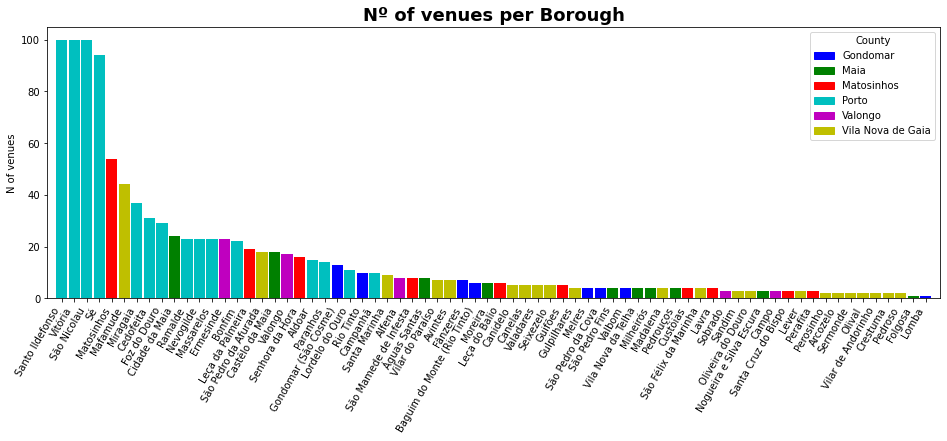

In [42]:
venues_grouped = porto_venues.groupby('Borough')
venues1=porto_venues['Borough'].value_counts()
venues1=venues1.to_frame(name='N of venues')
venues1['County']=venues1.index.map(merged_df.set_index('Borough')['County Name'].to_dict())
venues1.sort_values('N of venues', inplace=True, ascending=False)

color_map = {'Gondomar':'b', 'Maia' : 'g', 'Matosinhos' : 'r', 'Porto' : 'c', 'Valongo' : 'm', 'Vila Nova de Gaia' : 'y'}

colors= venues1['County'].map(color_map)
Patches=[]
for value in color_map.values():
    Patches.append(Patch(color=value))


f, ax = plt.subplots(figsize=(16,5))
ax.margins(0.01, 0.05)
plt.bar(venues1.index,venues1['N of venues'],color=colors, width=0.9)
plt.legend(Patches,list(color_map.keys()), title='County')
plt.ylabel('N of venues')

plt.xticks(rotation = 60, ha='right')
plt.title('Nº of venues per Borough', fontsize=18, fontweight='bold')

plt.show()

In [43]:

restaurantes=venues_grouped['Is a restaurant'].sum()
restaurantes=restaurantes.to_frame(name='Number of restaurants')
restaurantes

,Number of restaurants
Borough,
Aldoar,1.0
Alfena,1.0
Arcozelo,0.0
Avintes,2.0
Baguim do Monte (Rio Tinto),4.0
...,...
Vila Nova da Telha,2.0
Vilar de Andorinho,1.0
Vilar do Paraíso,1.0


Let's plot the number of restaurants per Borough

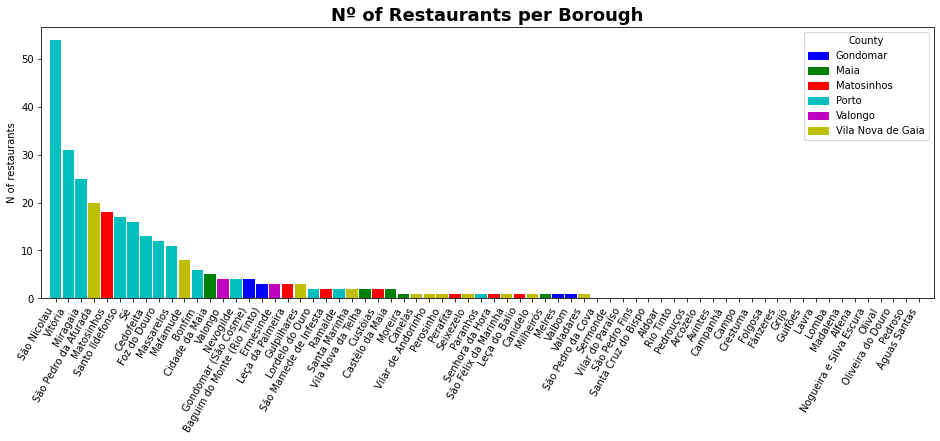

In [206]:
restaurantes=venues_grouped['Is a restaurant'].sum()
restaurantes=restaurantes.to_frame(name='Number of restaurants')
restaurantes['County']=restaurantes.index.map(merged_df.set_index('Borough')['County Name'].to_dict())
restaurantes.sort_values('Number of restaurants', inplace=True, ascending=False)

colors= restaurantes['County'].map(color_map)
Patches=[]
for value in color_map.values():
    Patches.append(Patch(color=value))


f, ax = plt.subplots(figsize=(16,5))
ax.margins(0.01, 0.05)
plt.bar(restaurantes.index,restaurantes['Number of restaurants'],color=colors, width=0.9)

plt.legend(Patches,list(color_map.keys()), title='County')
plt.ylabel('N of restaurants')

plt.xticks(rotation = 60, ha='right')
plt.title('Nº of Restaurants per Borough', fontsize=18, fontweight='bold')

plt.show()


## Let's analyze each neighborhood and cluster them by types of nearby venues with the KMeans algorithm

In [44]:
porto_onehot = pd.get_dummies(porto_venues[['Venue Category']], prefix="", prefix_sep="")

porto_onehot['Borough'] = porto_venues['Borough']

fixed_columns = [porto_onehot.columns[-1]] + list(porto_onehot.columns[:-1])
porto_onehot = porto_onehot[fixed_columns]
porto_onehot.shape

(1073, 168)

In [45]:
porto_grouped = porto_onehot.groupby('Borough').mean().reset_index()
porto_grouped.shape

(70, 168)

In [46]:
porto_grouped

,Borough,African Restaurant,Airport Terminal,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Aldoar,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,Alfena,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Arcozelo,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,Avintes,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,Baguim do Monte (Rio Tinto),0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.166667,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vila Nova da Telha,0.00,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
66,Vilar de Andorinho,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
67,Vilar do Paraíso,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
68,Vitória,0.01,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.000000,0.02,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0


Let's do the Cluster analysis with k-means

In [47]:
from sklearn.cluster import KMeans

In [48]:
cluster_df = porto_grouped.drop('Borough', 1)

kmeans = KMeans(n_clusters=6, random_state=2).fit(cluster_df)

kmeans.labels_[0:10]

array([5, 5, 5, 2, 3, 3, 5, 5, 5, 3])

The number of Boroughs decrease from the begining, so there are a few places for where Foursquare API did not return any Venues. We need to take that into account when doing the join

In [49]:
porto_grouped['Cluster label']=kmeans.labels_

porto_grouped.tail(10)

,Borough,African Restaurant,Airport Terminal,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Veterinarian,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Cluster label
60,São Pedro da Cova,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5
61,Sé,0.010638,0.00,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,...,0.031915,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,3
62,Valadares,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
63,Valbom,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5
64,Valongo,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
65,Vila Nova da Telha,0.000000,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
66,Vilar de Andorinho,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2
67,Vilar do Paraíso,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
68,Vitória,0.010000,0.00,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,...,0.020000,0.0,0.0,0.0,0.030000,0.0,0.0,0.0,0.0,3
69,Águas Santas,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2


In [50]:
porto_grouped['Cluster label'].value_counts()

3    29
5    26
2     9
1     3
4     2
0     1
Name: Cluster label, dtype: int64

The clustering provided some unbalanced results. Let's look closer at the venues in the 0 4 1 clusters

In [52]:
porto_venues['Cluster label']=porto_venues['Borough'].map(porto_grouped.set_index('Borough')['Cluster label'].to_dict())

In [53]:
porto_venues[porto_venues['Cluster label'].isin([1,4,0])]


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Is a restaurant,Cluster label
6,Fânzeres,41.171271,-8.542779,Gare Café,41.173816,-8.547589,Café,False,1
7,Fânzeres,41.171271,-8.542779,Madureira Venda Nova,41.174508,-8.545728,Snack Place,False,1
8,Fânzeres,41.171271,-8.542779,Venda Nova,41.170536,-8.546393,Plaza,False,1
9,Fânzeres,41.171271,-8.542779,Pingo Doce,41.171397,-8.547699,Supermarket,False,1
10,Fânzeres,41.171271,-8.542779,Mercadona Rio Tinto,41.168815,-8.542178,Supermarket,False,1
11,Fânzeres,41.171271,-8.542779,Café Capa Negra,41.170442,-8.546345,Bakery,False,1
12,Fânzeres,41.171271,-8.542779,Metro Venda Nova [F],41.175293,-8.542189,Light Rail Station,False,1
38,Lomba,41.061741,-8.410817,Bar da praia da Lomba,41.061516,-8.413015,Bar,False,4
98,Folgosa,41.266578,-8.540036,Piscinas Municipais de Folgosa Maia,41.268005,-8.545596,Pool,False,0
113,Pedrouços,41.187801,-8.587277,Pão Quente Doce Linda,41.188488,-8.584507,Bakery,False,1


## The clustering does not look very promising.
Let's check cluster 2 3 5 more closely and think about dropping the other clusters

In [54]:
venues_c2=porto_venues['Venue Category'][porto_venues['Cluster label']==2].value_counts()
venues_c2

Bakery                      13
BBQ Joint                    4
Park                         3
Plaza                        3
Portuguese Restaurant        3
Electronics Store            2
Pharmacy                     2
Café                         1
Restaurant                   1
Gym / Fitness Center         1
Mediterranean Restaurant     1
Coffee Shop                  1
Breakfast Spot               1
Bar                          1
Soccer Field                 1
Supermarket                  1
Pizza Place                  1
Light Rail Station           1
Train Station                1
Brewery                      1
Name: Venue Category, dtype: int64

In [55]:
venues_c3=porto_venues['Venue Category'][porto_venues['Cluster label']==3].value_counts()
venues_c3

Portuguese Restaurant          101
Restaurant                      44
Café                            42
Tapas Restaurant                41
Hotel                           28
                              ... 
Dive Bar                         1
Other Great Outdoors             1
Eastern European Restaurant      1
Bagel Shop                       1
Modern European Restaurant       1
Name: Venue Category, Length: 147, dtype: int64

In [56]:
venues_c5=porto_venues['Venue Category'][porto_venues['Cluster label']==5].value_counts()
venues_c5

Café                     51
Bakery                   20
Restaurant               11
Portuguese Restaurant     8
Coffee Shop               8
                         ..
Water Park                1
Art Museum                1
Farmers Market            1
Deli / Bodega             1
Beer Store                1
Name: Venue Category, Length: 74, dtype: int64

Cluster 3 has a bunch of restaurants, while the other clusters appear to not be as crowded

In [73]:

merged_df['Cluster label']= merged_df['Borough'].map(porto_grouped.set_index('Borough')['Cluster label'].to_dict())
merged_df.head(5)

,Borough,Code,€ m2,County Code,County Name,Latitude,Longitude,Density,Ppower,Cluster label
0,Baguim do Monte (Rio Tinto),11A130412,5.66,04,Gondomar,41.187473,-8.537759,1258.2,98.162433,3.0
1,Fânzeres,11A130413,4.58,04,Gondomar,41.171271,-8.542779,1258.2,79.431792,1.0
2,Covelo,11A130414,4.58,04,Gondomar,41.102164,-8.465754,1258.2,79.431792,NaN
3,Gondomar (São Cosme),11A130415,4.93,04,Gondomar,41.135273,-8.534104,1258.2,85.501908,5.0
4,Valbom,11A130415,4.93,04,Gondomar,41.137576,-8.562042,1258.2,85.501908,5.0


Let's replace the missing values in the cluster label with 6 (boroughs without any venue in foursquare)

In [76]:
merged_df['Cluster label']=merged_df['Cluster label'].fillna(6)
merged_df['Cluster label']=merged_df['Cluster label'].astype(int)

In [77]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [78]:

kclusters = 7
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough'], merged_df['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As said above, we would prefer to locate the restaurante anywhere but in cluster 3.

By logic, we would want to choose a place with high pop. density, purchasing power (to have a higher number of customers, willing to pay more) and low price per m2 of rent.

A good rule of thumb for restaurants is to have ~1 m2 available per customer. You want your kitchen to be ~40% of the total area. So for a 60 people restaurant, a good estimate would be to have 100 m2 of area.

Let's remove the cluster 3 Boroughs and do some analysis on the remaining ones. estimating a monthly rent and creating a (0 to 1) index for customersXprice (expected income)

In [94]:
remaining_df=merged_df[['Borough','Density','Ppower','€ m2','Cluster label']][~(merged_df['Cluster label']==3)]
remaining_df['estimated monthly rent']=100*remaining_df['€ m2']
remaining_df.head(5)

,Borough,Density,Ppower,€ m2,Cluster label,estimated monthly rent
1,Fânzeres,1258.2,79.431792,4.58,1,458.0
2,Covelo,1258.2,79.431792,4.58,6,458.0
3,Gondomar (São Cosme),1258.2,85.501908,4.93,5,493.0
4,Valbom,1258.2,85.501908,4.93,5,493.0
5,Jovim,1258.2,85.501908,4.93,6,493.0


In [95]:
remaining_df['expected income index']=remaining_df['Density']*remaining_df['Ppower']
remaining_df.head(5)

,Borough,Density,Ppower,€ m2,Cluster label,estimated monthly rent,expected income index
1,Fânzeres,1258.2,79.431792,4.58,1,458.0,99941.081203
2,Covelo,1258.2,79.431792,4.58,6,458.0,99941.081203
3,Gondomar (São Cosme),1258.2,85.501908,4.93,5,493.0,107578.500072
4,Valbom,1258.2,85.501908,4.93,5,493.0,107578.500072
5,Jovim,1258.2,85.501908,4.93,6,493.0,107578.500072


Let's normalize the result to get the index

In [103]:
remaining_df['expected income index']=remaining_df['expected income index']/remaining_df['expected income index'].max()

remaining_df=remaining_df.reset_index(drop=True)
remaining_df['expected income index']

0     0.116154
1     0.116154
2     0.125031
3     0.125031
4     0.125031
5     0.116154
6     0.116154
7     0.116154
8     0.116154
9     0.116154
10    0.144052
11    0.200922
12    0.218903
13    0.200922
14    0.241966
15    0.236493
16    0.200922
17    0.338806
18    0.455881
19    0.455881
20    0.363640
21    0.338806
22    0.363640
23    0.892632
24    1.000000
25    0.793684
26    0.989474
27    0.110787
28    0.110787
29    0.156441
30    0.172524
31    0.229779
32    0.216128
33    0.189586
34    0.192241
35    0.233570
36    0.191482
37    0.206270
38    0.172524
39    0.218403
40    0.152048
41    0.261629
42    0.189586
43    0.152048
44    0.189586
45    0.236983
46    0.189586
Name: expected income index, dtype: float64

Let's plot, ideally we want Boroughs located in the 1st quadrant (high on both scores)

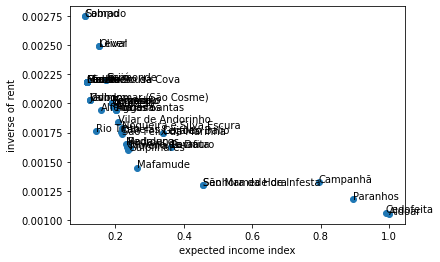

In [105]:
x= remaining_df['expected income index']
y=1/remaining_df['estimated monthly rent']
labels=remaining_df['Borough']


fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_ylabel('inverse of rent')
ax.set_xlabel('expected income index')

for i, txt in enumerate(remaining_df['Borough'].to_list()):
    ax.annotate(txt, (x[i], y[i]))

No clear winners emerge yet. Let's look into the top dogs in Expected income index

In [110]:
abc=remaining_df.sort_values('expected income index', ascending=False)
abc=abc.head(10)
abc=abc.reset_index(drop=True)

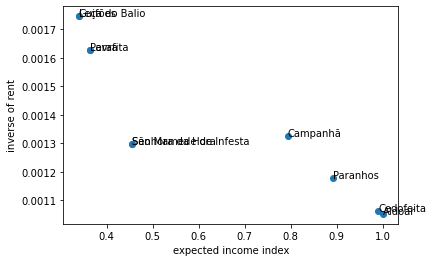

In [111]:
x= abc['expected income index']
y=1/abc['estimated monthly rent']
labels=abc['Borough']


fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_ylabel('inverse of rent')
ax.set_xlabel('expected income index')

for i, txt in enumerate(abc['Borough'].to_list()):
    ax.annotate(txt, (x[i], y[i]))

In [112]:
abc

,Borough,Density,Ppower,€ m2,Cluster label,estimated monthly rent,expected income index
0,Aldoar,5229.5,164.531353,9.50,5,950.0,1.000000
1,Cedofeita,5229.5,162.799444,9.40,5,940.0,0.989474
2,Paranhos,5229.5,146.865881,8.48,5,848.0,0.892632
3,Campanhã,5229.5,130.585937,7.54,5,754.0,0.793684
4,São Mamede de Infesta,2809.3,139.624558,7.71,5,771.0,0.455881
5,Senhora da Hora,2809.3,139.624558,7.71,5,771.0,0.455881
6,Lavra,2809.3,111.373675,6.15,1,615.0,0.363640
7,Perafita,2809.3,111.373675,6.15,5,615.0,0.363640
8,Leça do Balio,2809.3,103.767668,5.73,5,573.0,0.338806
9,Guifões,2809.3,103.767668,5.73,5,573.0,0.338806


We are now ready to provide a recommendation.

It depends on the type of price we want to set and how many customers we expect to atract.

In Porto, Aldoar and Cedofeita appear good options for a more high end restaurant, for ~200€ a month less, Campanhã has a nice balance between density and rent prices. 
Guifões and Leça do Balio in Matosinhos seem good options for low price restaurants as they are still fairly dense and rent prices are lower.

It would be good if we had information on Density per Borough as we expect them to deviate significantly from the County average and influence the obtained results.